# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None
state = np.random.RandomState(12345)

In [2]:
#читаем датафайлы
df_0 = pd.read_csv('/datasets/geo_data_0.csv') #данные по 0 региону
df_1 = pd.read_csv('/datasets/geo_data_1.csv') #данные по 1 региону
df_2 = pd.read_csv('/datasets/geo_data_2.csv') #по 2ому

In [3]:
#первый взгляд на наши файлы
for i in [df_0, df_1, df_2]:
    display(i.head(3))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


`id` - это уникальный индентификатор скважины. В будущем мы их удалим, что бы уникальные значения не перегружали модель    
`f0,f1,f2` - колонки признаков (при том не дана информация, что они означают, но известно, что признаки значимы)    
`product` - объём запасов в скважине (в тысячах баррелях).

In [4]:
#проверяем размер таблицы
for i in [df_0, df_1, df_2]:
    display(i.shape)

(100000, 5)

(100000, 5)

(100000, 5)

В ходе обработки данных было обнаруженно, что в `id` есть повторяющиеся значения

In [5]:
#вывожу все колонки с повторяющимися id
for i in [df_0, df_1, df_2]:
    display(i[i['id'].duplicated(keep = False)].sort_values(by ='id'))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Конечно, повторы в `id` для данного проекта нас не сильно беспокоят. Но хорошим тоном будет сообщить о данной проблеме

In [6]:
#делаем проверку на наличие пропусков
for i,y in zip([df_0, df_1, df_2], ['df_0', 'df_1', 'df_2']):
    print(f'Количество пропущенных значений в {y}\n{i.isna().sum()}\n')

Количество пропущенных значений в df_0
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество пропущенных значений в df_1
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество пропущенных значений в df_2
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



In [7]:
#взглянем на наши данные по подробнее
for i in [df_0, df_1, df_2]:
    display(i.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Данные по своим характеристикам очень сильно разнятся.   
У меня была идея объединить их при помощи `concat`. Потом обучить модель.   
Ибо таким образом на тренировочную модель мы бы выдали 22_500 строк, а не обучали 3 модели по  7_500 строк.   
И далее при помощь `.loc` разбить их по 3 датасетам с информацией о каждом регионе   

Но недостатком данного решения будет   
1) У нас нет уверенности, что в разных районах по одинковому расчитывались признаки. И тогда перемешивание данных приведёт нас к тому, что модель плохо обучится   
2) В ходе разделения при помощи `train_test_split` на ключевой выборке у нас может получится разное количество строк для каждого из регионов


По этому остановимся на варианте, где мы будем обучать модели ML для каждого региона по отдельности 

In [8]:
#создаём датасеты с признаками для 3ех регионов  удаляя уникальные id и значения целового признака
features_0 = df_0.drop(['id', 'product'], axis = 1)  
features_1 = df_1.drop(['id', 'product'], axis = 1)
features_2 = df_2.drop(['id', 'product'], axis = 1)

#датасеты с целевым призаком 
target_0 = df_0['product']
target_1 = df_1['product']
target_2 = df_2['product']

In [9]:
#разбиваем на тренировочную (0.75) и валидационную (0.25) выборку 

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size = 0.25, random_state = 12345)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size = 0.25, random_state = 12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size = 0.25, random_state = 12345)

In [10]:
#делаю проверку на то как разбились данные
print('Размеры выборок')
print(f'Тренировочная с признаками: {features_train_0.shape}\nВалидационная с признакми: {features_valid_0.shape}\n')
print(f'Тренировочная с целевым признаком: {target_train_0.shape}\nВалидационная с целевым признаком: {target_valid_0.shape}')

Размеры выборок
Тренировочная с признаками: (75000, 3)
Валидационная с признакми: (25000, 3)

Тренировочная с целевым признаком: (75000,)
Валидационная с целевым признаком: (25000,)


In [11]:
#провожу масштабирование признаков
scaler = StandardScaler()

scaler.fit(features_train_0)
features_train_0 = scaler.transform(features_train_0)
features_valid_0 = scaler.transform(features_valid_0)

scaler.fit(features_train_1)
features_train_1 = scaler.transform(features_train_1)
features_valid_1 = scaler.transform(features_valid_1)

scaler.fit(features_train_2)
features_train_2 = scaler.transform(features_train_2)
features_valid_2 = scaler.transform(features_valid_2)

Далее покажу что сделало наше масштабирование  
Благодаря  нему у нас среднее будет стремиться к нулю (в идеале будет = 0). 
А стандартное отклонение будет равно = 1   

Данное масштабирование очень сильно облегчает процесс обучения модели 

In [12]:
pd.DataFrame(features_train_0).describe()

,0,1,2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,1.680907e-16,-3.474554e-17,6.442254e-18
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.186288e+00,-2.178269e+00,-3.890945e+00
25%,-6.575544e-01,-8.925344e-01,-6.799576e-01
50%,1.878842e-03,-7.407961e-04,4.288679e-03
75%,6.571176e-01,8.928514e-01,6.829752e-01
max,2.139081e+00,2.169192e+00,4.153623e+00


Что и следовало доказать. Мы смогли масштабировать наши признаки 

### Вывод

В данных пропусков и дубликатов нет. 
Было проведено разбиение на целевую и обучающюю выборку. Так же была проведена проверка на разбиение. 
И сделано шкалирование признаков. 

Мы готовы приступить к ML

## Обучение и проверка модели

In [13]:
model = LinearRegression() #модель линейной регрессии 


model.fit(features_train_0, target_train_0) #обучение модели для 0 региона
predictions_valid_0 = model.predict(features_valid_0) #предсказания
print(f'Регион 0 \nСредний запас предсказанного сырья: {predictions_valid_0.mean()}')
print(f'RMSE:{mean_squared_error(target_valid_0,predictions_valid_0) **0.5}\n')


model.fit(features_train_1, target_train_1) #обучение модели для 1 региона
predictions_valid_1 = model.predict(features_valid_1) #предсказания 
print(f'Регион 1 \nСредний запас предсказанного сырья: {predictions_valid_1.mean()}')
print(f'RMSE:{mean_squared_error(target_valid_1,predictions_valid_1) **0.5}\n')


model.fit(features_train_2, target_train_2) #обучение модели для 2 региона 
predictions_valid_2 = model.predict(features_valid_2) #предсказания
print(f'Регион 2 \nСредний запас предсказанного сырья: {predictions_valid_2.mean()}')
print(f'RMSE:{mean_squared_error(target_valid_2,predictions_valid_2) **0.5}\n')

Регион 0 
Средний запас предсказанного сырья: 92.59256778438035
RMSE:37.5794217150813

Регион 1 
Средний запас предсказанного сырья: 68.728546895446
RMSE:0.893099286775617

Регион 2 
Средний запас предсказанного сырья: 94.96504596800489
RMSE:40.02970873393434



Создаём датафреймы с реальным значением  сырья в скважине и какое значение предсказывает ML

In [14]:
df0 = pd.concat([target_valid_0.reset_index(drop = True), pd.Series(predictions_valid_0)], axis = 1)
df0.rename(columns = {0: 'predictions'}, inplace = True)

df1 = pd.concat([target_valid_1.reset_index(drop = True), pd.Series(predictions_valid_1)], axis = 1)
df1.rename(columns = {0: 'predictions'}, inplace = True)

df2 = pd.concat([target_valid_2.reset_index(drop = True), pd.Series(predictions_valid_2)], axis = 1)
df2.rename(columns = {0: 'predictions'}, inplace = True)

In [15]:
#проверка того, какие получились датафреймы
for i in [df0, df1, df2]:
    display(i.head(3))

,product,predictions
0,10.038645,95.894952
1,114.551489,77.572583
2,132.603635,77.892640


,product,predictions
0,80.859783,82.663314
1,53.906522,54.431786
2,30.132364,29.748760


,product,predictions
0,61.212375,93.599633
1,41.850118,75.105159
2,57.776581,90.066809


Далее построим гистограммы того, как распределены у нас значения. 

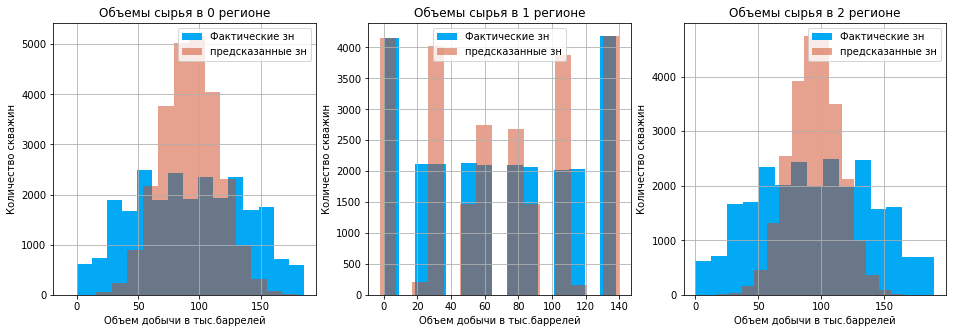

In [16]:
fig = plt.figure(figsize = (16,5))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)
df0['product'].hist(ax = ax0, facecolor = '#03A9F4', bins = 15)
df1['product'].hist(ax = ax1, facecolor = '#03A9F4', bins = 15)
df2['product'].hist(ax = ax2, facecolor = '#03A9F4', bins = 15)
df0['predictions'].hist(ax = ax0, facecolor = '#CF4720', alpha = 0.5, bins = 15)
df1['predictions'].hist(ax = ax1, facecolor = '#CF4720', alpha = 0.5, bins = 15)
df2['predictions'].hist(ax = ax2, facecolor = '#CF4720', alpha = 0.5, bins = 15)
ax0.set_title('Объемы сырья в 0 регионе')
ax0.set_xlabel('Объем добычи в тыс.баррелей')
ax0.set_ylabel('Количество скважин')
ax0.legend(['Фактические зн', 'предсказанные зн'])
ax1.set_title('Объемы сырья в 1 регионе')
ax1.set_xlabel('Объем добычи в тыс.баррелей')
ax1.set_ylabel('Количество скважин')
ax1.legend(['Фактические зн', 'предсказанные зн'])
ax2.set_title('Объемы сырья в 2 регионе')
ax2.set_xlabel('Объем добычи в тыс.баррелей')
ax2.set_ylabel('Количество скважин')
ax2.legend(['Фактические зн', 'предсказанные зн'])
plt.show();

### Вывод

Наши модели обучились и была проведена оценка качества данных моделей при помощи RMSE   

`Регион 0` и `Регион 2`   
Имеют высокие показатели среднего запаса предсказанного сырья    
Но имеют большую **RMSE**. Модели не очень хорошо обучились.    

`Регион 1`    
Имеют более низкий запас предсказанного сырья      
Но в противовес ошибка **RMSE** ниже 1    
    
Возможно(пока делаем предположение), что регион 1 будет более интересным для бизнеса. Да в среднем запас сырья ниже, но очень высока предсказательная сила и мы сможем с большей вероятностью точно находить наилучшие скважины.     
Далее проверим это предположение     

Так же можно предположить, что в разных регионах по разному собирали данные. И что в 1ом регионе качество данных более высокое.


*P.s. смотря на гистограммы можно сказать что в 1ом регионе данные созданы искусственно, тогда как в 0 и 2 регионе они похожи на нормальное распределение*  

## Подготовка к расчёту прибыли

In [17]:
#Выводим реальные средние запасы топлива в регионах
for i in [df0, df1, df2]:
    print('Средний запас топлива в точке добычи нефти {0:3.3f} в тыс. барелях:'.format(i['product'].mean()))

Средний запас топлива в точке добычи нефти 92.079 в тыс. барелях:
Средний запас топлива в точке добычи нефти 68.723 в тыс. барелях:
Средний запас топлива в точке добычи нефти 94.884 в тыс. барелях:


Так же как и с предсказанными даными наблюдаем, что в `регионе 0` и `регионе 1` имеются в среднем более большие запасы нефти 

### Константные значения

Далее создаётся список константных значений.   
В случае изменения ТЗ вы можете изменить константы, перезапустить код и сделать новые выводы 

In [18]:
POINTS = 500 #количество иследуемых точек 
BEST_POINTS = 200  #какое количество наилучших точек будет отбираться для разработки 
BUDGET = 10_000_000_000 #каков бюджет проекта
COST = 450_000 #стоимость тысячи баррелей сырья
CRITICAL = 0 #значения ниже этой отметки будут считаться убытком

Мной была добавлена новая константа `critical`. Она показывает какие значения мы будем считать убытком. 
По умолчанию все значения прибыли ниже 0 будут считаться убытком.

Вы можете изменить это значение. Что бы посмотреть вероятности того, что проект соберёт меньше заявлянной суммы

Узнаём сколько тысяч баррелей должна добывать 1 скважина, что бы проект вышел в ноль(принесёт столько же денег, сколько и было в него вложено)

In [19]:
print('достаточный объём сырья для безубыточной разработки новой скважины = {0:3.3f}'.format(BUDGET/BEST_POINTS/COST))

достаточный объём сырья для безубыточной разработки новой скважины = 111.111


### Вывод 

По показателям очень сильно проседает 1 регион. Всего 68.7 тыс.баррелей нефти в среднем.    
В противоположность 0 и 2 регионы имеют от 92 до 94.8 тыс. баррели нефти в среднем. 

Но показатели все равно очень низкие. Без машинного обучения не получится случайным образом определять точки для добычи нефти. 
Для работы в 0 окупаемость скважина должна иметь 111.1 тысяч. баррелей нефти.

Для получения прибыли мы должны найти самые лучшие точки для добычи нефти 

## Расчёт прибыли и рисков 

In [20]:
def profit(df):
    '''Выводит прибыль'''
    df = df.sort_values(by = 'predictions', ascending = False) #делаем сортировку по предсказанным значениям 
    df = df.iloc[0:BEST_POINTS - 1, 0] #отбираем необходимое количество месторождений с наилучшими предсказаниями
    value = df.sum() * COST - BUDGET  #узнаём прибыль 
    return value

In [21]:
def bootstrap(df):
    '''Делает бутстрап и считает прибыль каждого субсемпла'''
    values = []
    for i in range(1000):
        subsample = df.sample(n = POINTS, replace = True, random_state = state)
        values.append(profit(subsample))
    return pd.Series(values)

In [22]:
x0 = bootstrap(df0)
x1 = bootstrap(df1)
x2 = bootstrap(df2)

### Средняя прибыль в регионах

In [23]:
print(f'Ср. прибыль в 0 регионе = {int(x0.mean())}\nСр. прибыль в 1 регионе = {int(x1.mean())}')
print(f'Ср. прибыль в 2 регионе = {int(x2.mean())}')

Ср. прибыль в 0 регионе = 351865661
Ср. прибыль в 1 регионе = 423740378
Ср. прибыль в 2 регионе = 348544941


In [24]:
for i, y in zip([x0, x1, x2], ['0', '1', '2']):
    print(f'Cр. прибыль в {y} регионе = {int(i.mean())}')

Cр. прибыль в 0 регионе = 351865661
Cр. прибыль в 1 регионе = 423740378
Cр. прибыль в 2 регионе = 348544941


### Вероятность убытков 

In [25]:
for i, y in zip([x0, x1, x2], ['0', '1', '2']):
    print(f'Вероятность убытков в {y} регионе = {round((i<CRITICAL).mean()*100, 3)} %')

Вероятность убытков в 0 регионе = 9.1 %
Вероятность убытков в 1 регионе = 1.4 %
Вероятность убытков в 2 регионе = 8.7 %


### 95% доверительный интервал 

In [26]:
for i,y in zip([x0, x1, x2], ['0', '1', '2']):
    print('95% доверительный интревал',y,'го региона {0:.10} - {1:.10}'.format(i.quantile(0.025), i.quantile(0.975)))

95% доверительный интревал 0 го региона -142174410.7 - 868141756.0
95% доверительный интревал 1 го региона 41663908.36 - 825134561.7
95% доверительный интревал 2 го региона -167243264.0 - 888362423.6


### Вывод 
По всем показателям лучше всего показывает себя 1ый регион. Это как раз связано с тем, что ML модель хорошо обучилась на первом регионе и она чаще будет определять лучшие месторождения 

## Общий вывод 

Для разработки месторождений предлагается 1 регион.   

Причиной выбора 1го региона является:   
1) Более высокая средняя прибыль  
2) Вероятность понести убытки всего 1.4% против 9.1% и 8.7% 

По поводу первого региона можно сказать, что в среднем он имеет более низкие запасы нефти(+напоминаю, что там около 4тысяч нефтерождений с менее 10 тыс. бареллей нефти), но он лучше всего нам подходит из-за того, что ML модель в этом регионе с большей вероятностью правильно определяет наилучшие нефтерождения и она очень хорошо отсеивает убыточные.   

По поводу ML моделей в других регионах они могут сильно ошибаться с предсказаниеми и мы начнём разрабатывать изначально убыточные нефтерождения. 
Если будет решено разрабатывать нефтерождения в других регионах (из-за более высоких средних показателей количества нефти), то рекомендуется собрать новые/более качественные данные для обучения ML модели. Иначе вероятность финансовых потерь будет очень высока. 